# Protein MD Setup tutorial using BioExcel Building Blocks (biobb) through REST API
**Based on the official GROMACS tutorial:** [http://www.mdtutorials.com/gmx/lysozyme/index.html](http://www.mdtutorials.com/gmx/lysozyme/index.html)
***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein**, step by step, using the **BioExcel Building Blocks (biobb) [REST API](http://mmb.irbbarcelona.org/biobb-api)**. The particular example used is the **Lysozyme** protein (PDB code 1AKI). 
***

## Settings
 
### Auxiliar libraries used

 - [requests](https://pypi.org/project/requests/): Requests allows you to send *organic, grass-fed* HTTP/1.1 requests, without the need for manual labor. 
 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
 - [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.

### Conda Installation and Launch

```console
 git clone https://github.com/bioexcel/biobb_wf_md_setup_api.git
 cd biobb_wf_md_setup_api
 conda env create -f conda_env/environment.yml
 conda activate biobb_MDsetupAPI_tutorial
 jupyter-nbextension enable --py --user widgetsnbextension
 jupyter-nbextension enable --py --user nglview
 jupyter-notebook biobb_wf_md_setup_api/notebooks/biobb_MDsetupAPI_tutorial.ipynb
  ``` 

***
 
## Pipeline steps
 1. [Define global functions](#global)
 2. [Input Parameters](#input)
 3. [Fetching PDB Structure](#fetch)
 4. [Fix Protein Structure](#fix)
 5. [Create Protein System Topology](#top)
 6. [Create Solvent Box](#box)
 7. [Fill the Box with Water Molecules](#water)
 8. [Adding Ions](#ions)
 9. [Energetically Minimize the System](#min)
 10. [Equilibrate the System (NVT)](#nvt)
 11. [Equilibrate the System (NPT)](#npt)
 12. [Free Molecular Dynamics Simulation](#free)
 13. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 14. [Output Files](#output)
 
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


<a id="global"></a>
## Define global functions
These global functions are used for sending and retrieving data to / from the REST API. [Click here](http://mmb.irbbarcelona.org/biobb-api/tutorial) for more information about how the BioBB REST API works and which is the purpose for each of these functions.

In [1]:
import requests
import json
import datetime
from time import sleep
from io import BytesIO
from pathlib import Path

class Response:
  def __init__(self, status, json):
    self.status = status
    self.json = json

def get_data(url):
    r = requests.get(url)
    return Response(r.status_code, json.loads(r.text))
    
def post_data(url, d, f):
    r = requests.post(url, data = d, files = f)
    return Response(r.status_code, json.loads(r.text))
    
def check_status(url, ok, error):
    counter = 0
    while True:
        if counter < 10: slp = 1
        if counter >= 10 and counter < 60: slp = 10
        if counter >= 60: slp = 60
        counter = counter + slp
        sleep(slp)
        r = requests.get(url)
        if r.status_code == ok or r.status_code == error:
            return counter
            break

def get_file(url, filename):
    r = requests.get(url, allow_redirects=True)
    file = open(filename,'wb') 
    file.write(r.content) 
    file.close()
    
def encode_config(data):
    jsonData = json.dumps(data)
    binaryData = jsonData.encode()
    return BytesIO(binaryData)

def launch_job(url, **kwargs):
    data = {}
    files = {}
    # Fill data (output paths) and files (input files) objects
    for key, value in kwargs.items():
        # Inputs / Outputs
        if type(value) is str:
            if key.startswith('input'):
                files[key] = (value,  open(value, 'rb'))
            elif key.startswith('output'):
                data[key] = value
            elif Path(value).is_file():
                files[key] = (value,  open(value, 'rb'))
        # Properties (in case properties are provided as a dictionary instead of a file)
        if type(value) is dict:
            files['config'] = ('prop.json', encode_config(value))
    # Request URL with data and files
    response = post_data(url, data, files)
    # Print REST API response
    print(json.dumps(response.json, indent=2))
    # Save token if status == 303
    if response.status == 303:
        token = response.json['token']
        return token            
    
def check_job(token):
    # define retrieve status URL
    url = apiURL + 'retrieve/status/' + token
    # check status until job has finished
    counter = check_status(url, 200, 500)
    # Get content when status = 200
    response = get_data(url)
    # Save id for the generated output_files
    if response.status == 200:
        out_files = []
        for outf in response.json['output_files']:
            item = { 'id': outf['id'], 'name': outf['name'] }
            out_files.append(item)

    # Print REST API response
    print("Total elapsed time: %s" % str(datetime.timedelta(seconds=counter)))
    print("REST API JSON response:")
    print(json.dumps(response.json, indent=2))
    
    if response.status == 200: 
        return out_files
    else: return None

def retrieve_data(out_files):
    if not out_files:
        return "No files provided"
    for outf in out_files:
        get_file(apiURL + 'retrieve/data/' + outf['id'], outf['name'])

<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein structure (e.g. 1AKI)
 - **apiURL**: Base URL for the Biobb REST API (http://mmb.irbbarcelona.org/biobb-api/rest/v1/)

In [2]:
import nglview
import ipywidgets

pdbCode = "1AKI"
apiURL  = "http://mmb.irbbarcelona.org/biobb-api/rest/v1/"

<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein molecule** from the RCSB PDB database.<br>
Alternatively, a **PDB file** can be used as starting structure. <br>

***
**BioBB REST API** end points used:
 - [PDB](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_io/pdb) from **biobb_io.api.pdb**
***

In [3]:
# Downloading desired PDB file

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode + '.pdb'
prop = {
    'pdb_code': pdbCode
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_io/pdb', 
                   config = prop,
                   output_pdb_path = downloaded_pdb)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "fb6ba90e833019dec650dc392de9f5f554d0e2fdeab9251acc90d862430417620952d4ca61c07c4086b3134bb45a4138da37e170422331fc048b3a2db8ccfeae"
}


In [4]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:03
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d28cd21c0.14909768",
      "name": "1AKI.pdb",
      "size": 81081,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [5]:
# Save generated file to disk
retrieve_data(out_files)

<a id="vis3D"></a>
### Visualizing 3D structure
Visualizing the downloaded/given **PDB structure** using **NGL**:    

In [84]:
# Show protein
view = nglview.show_structure_file(downloaded_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

In [85]:
view.render_image()
view.download_image(filename='ngl1.png')

<img src='ngl1.png'></img>

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**BioBB REST API** end points used:
 - [FixSideChain](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_model/fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [7]:
# Check & Fix PDB

# Create inputs/outputs
fixed_pdb = pdbCode + '_fixed.pdb'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_model/fix_side_chain',
                   input_pdb_path = downloaded_pdb,
                   output_pdb_path = fixed_pdb)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "b35753644fa7f3473eaee8ccfd7d818cfa15ba0ee6fb4097487bb4997142290029af14c28367777e07693e4ca4a672b2d7854b3f3b7115258f39972a159ab1f8"
}


In [8]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:05
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d3766f762.36442092",
      "name": "1AKI_fixed.pdb",
      "size": 81167,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [9]:
# Save generated file to disk
retrieve_data(out_files)

### Visualizing 3D structure
Visualizing the fixed **PDB structure** using **NGL**. In this particular example, the checking step didn't find any issue to be solved, so there is no difference between the original structure and the fixed one.   

In [86]:
# Show protein
view = nglview.show_structure_file(fixed_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [88]:
view.render_image()
view.download_image(filename='ngl2.png')

<img src="ngl2.png"></img>

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**BioBB REST API** end points used:
 - [Pdb2gmx](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/pdb2gmx) from **biobb_md.gromacs.pdb2gmx**
***

In [11]:
# Create system topology

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode + '_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode + '_pdb2gmx_top.zip'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/pdb2gmx', 
                   input_pdb_path = fixed_pdb,
                   output_gro_path = output_pdb2gmx_gro,
                   output_top_zip_path = output_pdb2gmx_top_zip)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "4acc79ab5a0c588bfaf711259562d6ecd6f33304bef8b53f2a1e9a9620cf348a0964316f6804df9b7c1743648519290191d29037e27ee4a776b29e7426a69728"
}


In [12]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:05
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d467ddc88.64790887",
      "name": "1AKI_pdb2gmx.gro",
      "size": 88274,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416d46809855.20806310",
      "name": "1AKI_pdb2gmx_top.zip",
      "size": 588581,
      "mimetype": "application/zip"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [13]:
# Save generated file to disk
retrieve_data(out_files)

### Visualizing 3D structure
Visualizing the generated **GRO structure** using **NGL**. Note that **hydrogen atoms** were added to the structure by the **pdb2gmx GROMACS tool** when generating the **topology**.    

In [90]:
# Show protein
view = nglview.show_structure_file(output_pdb2gmx_gro)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [91]:
view.render_image()
view.download_image(filename='ngl3.png')

<img src='ngl3.png'></img>

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein structure MD system** to fill it with water molecules.<br>
A **cubic box** is used to define the unit cell, with a **distance from the protein to the box edge of 1.0 nm**. The protein is **centered in the box**.  

***
**BioBB REST API** end points used:
 - [Editconf](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/editconf) from **biobb_md.gromacs.editconf**
***

In [15]:
# Editconf: Create solvent box

# Create properties dict and inputs/outputs
output_editconf_gro = pdbCode + '_editconf.gro'
prop = {
    'box_type': 'cubic',
    'distance_to_molecule': 1.0
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/editconf', 
                   config = prop,
                   input_gro_path = output_pdb2gmx_gro,
                   output_gro_path = output_editconf_gro)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "d58df4803759a83a4fdbb59628ff8a92e6d6f081fcdcd1240ca5f9abbf0998ff1f87c6f739a2198d634b21eb51e254fd70854b37ae4c117d4f02ea2b2839ed13"
}


In [16]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:01
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d54cde5e5.10594916",
      "name": "1AKI_editconf.gro",
      "size": 88274,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [17]:
# Save generated file to disk
retrieve_data(out_files)

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein structure system** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**BioBB REST API** end points used:
 - [Solvate](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/solvate) from **biobb_md.gromacs.solvate**
***

In [18]:
# Solvate: Fill the box with water molecules

# Create inputs/outputs
output_solvate_gro = pdbCode + '_solvate.gro'
output_solvate_top_zip = pdbCode + '_solvate_top.zip'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/solvate', 
                   input_solute_gro_path = output_editconf_gro,
                   input_top_zip_path = output_pdb2gmx_top_zip,
                   output_gro_path = output_solvate_gro,
                   output_top_zip_path = output_solvate_top_zip)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "9d38a026e927e9ad9eec9e2cc27c5d682dcfd43bf1586c329aaa0996833a94c714e5b48e151ab33cc5cd7e1fc4e18e234756ee3efb64da0b8c21ad1e81c5e49e"
}


In [19]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:20
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d64a73748.68698640",
      "name": "1AKI_solvate.gro",
      "size": 1525214,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416d64bc4be1.87083546",
      "name": "1AKI_solvate_top.zip",
      "size": 588612,
      "mimetype": "application/zip"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [20]:
# Save generated file to disk
retrieve_data(out_files)

### Visualizing 3D structure
Visualizing the **protein system** with the newly added **solvent box** using **NGL**.<br> Note the **cubic box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the cube.

In [92]:
# Show protein
view = nglview.show_structure_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='green')
view.add_representation(repr_type='ball+stick', selection='SOL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [93]:
view.render_image()
view.download_image(filename='ngl4.png')

<img src='ngl4.png'></img>

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein structure** charge
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system

***
**BioBB REST API** end points used:
 - [Grompp](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/grompp) from **biobb_md.gromacs.grompp**
 - [Genion](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/genion) from **biobb_md.gromacs.genion**
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation
A simple **energy minimization** molecular dynamics parameters (mdp) properties will be used to generate the portable binary run file for **ion generation**, although **any legitimate combination of parameters** could be used in this step.

In [22]:
# Grompp: Creating portable binary run file for ion generation

# Create prop dict and inputs/outputs
output_gppion_tpr = pdbCode + '_gppion.tpr'
prop = {
    'mdp':{
        'type': 'minimization'
    }
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/grompp', 
                   config = prop,
                   input_gro_path = output_solvate_gro,
                   input_top_zip_path = output_solvate_top_zip,
                   output_tpr_path = output_gppion_tpr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "f9ad8808d3cde3c6bdcb1189f85bcccdde2a06cb2c9d8bf08279a54fccf6c7a32fa7721dd7fc25f640d2295a3fb1de10a1cde2d73dd5a8f174109b2bb89a0501"
}


In [23]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:09
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d826fd8e4.58442682",
      "name": "1AKI_gppion.tpr",
      "size": 1398340,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [24]:
# Save generated file to disk
retrieve_data(out_files)

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system
Replace **solvent molecules** with **ions** to **neutralize** the system.

In [25]:
# Genion: Adding ions to neutralize the system

# Create prop dict and inputs/outputs
output_genion_gro = pdbCode + '_genion.gro'
output_genion_top_zip = pdbCode + '_genion_top.zip'
prop={
    'neutral':True
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/genion',
                   config = prop,
                   input_tpr_path = output_gppion_tpr,
                   input_top_zip_path = output_solvate_top_zip,
                   output_gro_path = output_genion_gro,
                   output_top_zip_path = output_genion_top_zip)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "35045786453b8518d080d63e1458e57b498ebb535baec269d5635cc0f1e380e0bdb369b8b10e2b08cb4101aa0b6240961cdabcad90d83b3785ac1d90df0eebd6"
}


In [26]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:08
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416d9119f513.58873166",
      "name": "1AKI_genion.gro",
      "size": 1522674,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416d916b0653.25734025",
      "name": "1AKI_genion_top.zip",
      "size": 588648,
      "mimetype": "application/zip"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [27]:
# Save generated file to disk
retrieve_data(out_files)

### Visualizing 3D structure
Visualizing the **neutralized protein system** with the newly added **ions** using **NGL**

In [94]:
# Show protein
view = nglview.show_structure_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='sstruc')
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

In [95]:
view.render_image()
view.download_image(filename='ngl5.png')

<img src='ngl5.png'></img>

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein system** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **system** till reaching a force of 500 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.

***
**BioBB REST API** end points used:
 - [Grompp](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/grompp) from **biobb_md.gromacs.grompp**
 - [Mdrun](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/mdrun) from **biobb_md.gromacs.mdrun**
 - [GMXEnergy](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_energy) from **biobb_analysis.gromacs.gmx_energy**
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
The **minimization** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **energy minimization**:

-  integrator  = steep ; Algorithm (steep = steepest descent minimization)
-  emtol       = 1000.0 ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
-  emstep      = 0.01 ; Minimization step size (nm)
-  nsteps      = 50000 ; Maximum number of (minimization) steps to perform

In this particular example, the method used to run the **energy minimization** is the default **steepest descent**, but the **maximum force** is placed at **500 KJ/mol\*nm^2**, and the **maximum number of steps** to perform (if the maximum force is not reached) to **5,000 steps**. 

In [29]:
# Grompp: Creating portable binary run file for mdrun

# Create prop dict and inputs/outputs
output_gppmin_tpr = pdbCode + '_gppmin.tpr'
prop = {
    'mdp':{
        'type': 'minimization',
        'emtol':'500',
        'nsteps':'5000'
    }
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/grompp', 
                   config = prop,
                   input_gro_path = output_genion_gro,
                   input_top_zip_path = output_genion_top_zip,
                   output_tpr_path = output_gppmin_tpr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "46fafe655baa5f38da771af5bdfe051a9a9a3f61e6e66d89b9656118d5072752d4115d97092bebf924b907117a5033fbe184e3dc98c302d7d4cec1f2593a3b99"
}


In [30]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:04
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416da0732cc0.84723225",
      "name": "1AKI_gppmin.tpr",
      "size": 1398800,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [31]:
# Save generated file to disk
retrieve_data(out_files)

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step. 

In [32]:
# Mdrun: Running minimization

# Create inputs/outputs
output_min_trr = pdbCode + '_min.trr'
output_min_gro = pdbCode + '_min.gro'
output_min_edr = pdbCode + '_min.edr'
output_min_log = pdbCode + '_min.log'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/mdrun', 
                   input_tpr_path = output_gppmin_tpr,
                   output_trr_path = output_min_trr,
                   output_gro_path = output_min_gro,
                   output_edr_path = output_min_edr,
                   output_log_path = output_min_log)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "95db9cc8eb1b056f3b1c43184c99df1653f857ed52b7a5090aa8886deb20a9942e5506bab47433da593eeb44e9aaa02c0e46a8e53e9ca1fc98e80690f878af4d"
}


In [33]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:01:00
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416ddcd72980.71409942",
      "name": "1AKI_min.trr",
      "size": 406152,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416ddcdd3c52.78022697",
      "name": "1AKI_min.gro",
      "size": 1522674,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416ddcf11c96.38395840",
      "name": "1AKI_min.edr",
      "size": 323376,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416ddd029a19.37415103",
      "name": "1AKI_min.log",
      "size": 769357,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [34]:
# Save generated file to disk
retrieve_data(out_files)

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [35]:
# GMXEnergy: Getting system energy by time 

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode + '_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_energy',
                   config = prop,
                   input_energy_path = output_min_edr,
                   output_xvg_path = output_min_ene_xvg)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "42b3521ebc12a36412e892aad2f45ccda13085a7653a79720350d10f660a4f9b2e80eec105f0c3cfc19684e4310d4644edf8240c4621ee172d43dbf14bcd1434"
}


In [36]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:01
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416deabcb943.96875510",
      "name": "1AKI_min_ene.xvg",
      "size": 46777,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [37]:
# Save generated file to disk
retrieve_data(out_files)

In [101]:
import plotly
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
}

plotly.offline.iplot(fig)

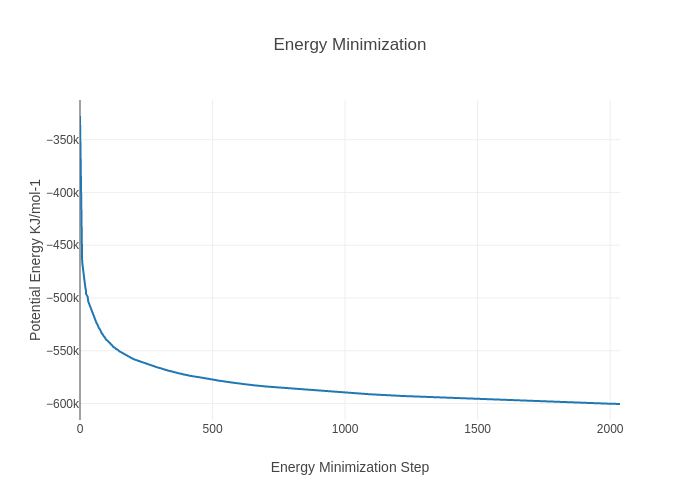

In [102]:
import plotly.io as pio
from IPython.display import Image
Image(pio.to_image(fig, format='png', width='700'))

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein system** in **NVT ensemble** (constant Number of particles, Volume and Temperature). Protein **heavy atoms** will be restrained using position restraining forces: movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to equilibrate our solvent around our protein, without the added variable of structural changes in the protein.

- [Step 1](#eqNVTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNVTStep2): Equilibrate the **protein system** with **NVT** ensemble.
- [Step 3](#eqNVTStep3): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 

***
**BioBB REST API** end points used:
 - [Grompp](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/grompp) from **biobb_md.gromacs.grompp**
 - [Mdrun](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/mdrun) from **biobb_md.gromacs.mdrun**
 - [GMXEnergy](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_energy) from **biobb_analysis.gromacs.gmx_energy**
***

<a id="eqNVTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NVT)
The **nvt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NVT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl                   = no
-  gen_vel                  = yes
-  gen_temp                 = 300
-  gen_seed                 = -1

In this particular example, the default parameters will be used: **md** integrator algorithm, a **step size** of **2fs**, **5,000 equilibration steps** with the protein **heavy atoms restrained**, and a temperature of **300K**.

*Please note that for the sake of time this tutorial is only running 10ps of NVT equilibration, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/06_equil.html) the simulated time was 100ps.*

In [39]:
# Grompp: Creating portable binary run file for NVT Equilibration

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode + '_gppnvt.tpr'
prop = {
    'mdp':{
        'type': 'nvt',
        'nsteps': 5000,
        'dt': 0.002,
        'define': '-DPOSRES',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/grompp',
                   config = prop,
                   input_gro_path = output_min_gro,
                   input_top_zip_path = output_genion_top_zip,
                   output_tpr_path = output_gppnvt_tpr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "3a00edf1ea74be30d3edfecc1c8881e44218938e3d9c2a026537e0d1980f34190bd691a4069122e8053c4ff473d31632be1f6328f6f71d99db9510966d897d82"
}


In [40]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:04
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416dfab33ef4.42640579",
      "name": "1AKI_gppnvt.tpr",
      "size": 1533904,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [41]:
# Save generated file to disk
retrieve_data(out_files)

<a id="eqNVTStep2"></a>
### Step 2: Running NVT equilibration

Running **energy minimization** using the **tpr file** generated in the previous step.

In [42]:
# Mdrun: Running Equilibration NVT

# Create inputs/outputs
output_nvt_trr = pdbCode + '_nvt.trr'
output_nvt_gro = pdbCode + '_nvt.gro'
output_nvt_edr = pdbCode + '_nvt.edr'
output_nvt_log = pdbCode + '_nvt.log'
output_nvt_cpt = pdbCode + '_nvt.cpt'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/mdrun',
                   input_tpr_path = output_gppnvt_tpr,
                   output_trr_path = output_nvt_trr,
                   output_gro_path = output_nvt_gro,
                   output_edr_path = output_nvt_edr,
                   output_log_path = output_nvt_log,
                   output_cpt_path = output_nvt_cpt)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "2eecb7b1372368938b0fc01e69aa1176255f0064887dba2af030066e0042126680b83959ee39f69978aadb087886326b0d0961119740d202b4ba4b010e215e17"
}


In [43]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:02:00
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416e3da506c9.99034113",
      "name": "1AKI_nvt.trr",
      "size": 8934024,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416e3e03dd30.69826125",
      "name": "1AKI_nvt.gro",
      "size": 2334738,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416e3e2262b7.45487547",
      "name": "1AKI_nvt.edr",
      "size": 6892,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416e3e23c9b7.26174822",
      "name": "1AKI_nvt.log",
      "size": 28665,
      "mimetype": "text/plain"
    },
    {
      "id": "5e416e3e255b83.37659135",
      "name": "1AKI_nvt.cpt",
      "size": 813800,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00

In [44]:
# Save generated file to disk
retrieve_data(out_files)

<a id="eqNVTStep3"></a>
### Step 3: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [45]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration 

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode + '_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_energy', 
                   config = prop,
                   input_energy_path = output_nvt_edr,
                   output_xvg_path = output_nvt_temp_xvg)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "b6aae3afb756c9390eeb6b159c8ca35c932db7c0ffdf78e17f946569c59f723615c839990812e3849b3096bedf010b728ffdd65524ee4e45c0d32901dc95e9fe"
}


In [46]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:20
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416e8fd2b0e1.23004567",
      "name": "1AKI_nvt_temp.xvg",
      "size": 275,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [47]:
# Save generated file to disk
retrieve_data(out_files)

In [103]:
import plotly
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg,'r') as temperature_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in temperature_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Temperature during NVT Equilibration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Temperature (K)")
                       )
}

plotly.offline.iplot(fig)

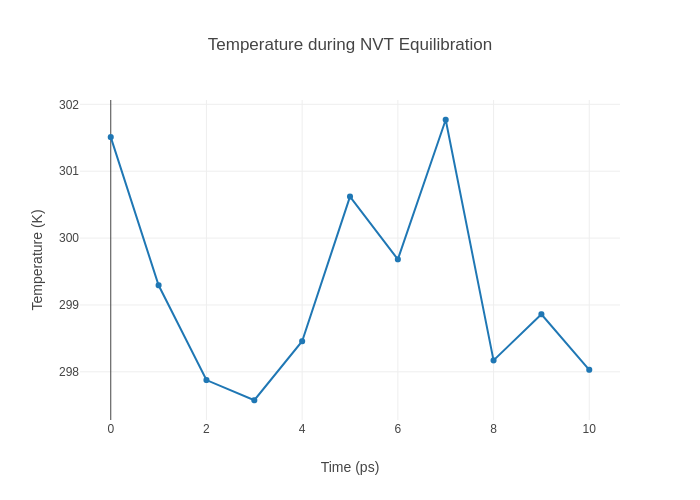

In [104]:
import plotly.io as pio
from IPython.display import Image
Image(pio.to_image(fig, format='png', width='700'))

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein system** in **NPT** ensemble (constant Number of particles, Pressure and Temperature).
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein system** with **NPT** ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**BioBB REST API** end points used:
 - [Grompp](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/grompp) from **biobb_md.gromacs.grompp**
 - [Mdrun](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/mdrun) from **biobb_md.gromacs.mdrun**
 - [GMXEnergy](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_energy) from **biobb_analysis.gromacs.gmx_energy**
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

The **npt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NPT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl = Parrinello-Rahman
-  pcoupltype = isotropic
-  tau_p = 1.0
-  ref_p = 1.0
-  compressibility = 4.5e-5
-  refcoord_scaling = com
-  gen_vel = no

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, **5,000 equilibration steps** with the protein **heavy atoms restrained**, and a Parrinello-Rahman **pressure coupling** algorithm.

*Please note that for the sake of time this tutorial is only running 10ps of NPT equilibration, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/07_equil2.html) the simulated time was 100ps.*

In [49]:
# Grompp: Creating portable binary run file for NPT System Equilibration

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode + '_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/grompp', 
                   config = prop,
                   input_gro_path = output_nvt_gro,
                   input_top_zip_path = output_genion_top_zip,
                   output_tpr_path = output_gppnpt_tpr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "bbfdbb1622100f3d894fafb957ccb985d427c8eeb0213c8473b1e3a5cb35c4f4266d9b2a188d1cbd975669de7503d9a21f38ed30c155901bde06003478c0f484"
}


In [50]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:05
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416eaebe8823.17967546",
      "name": "1AKI_gppnpt.tpr",
      "size": 1533904,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [51]:
# Save generated file to disk
retrieve_data(out_files)

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [52]:
# Mdrun: Running NPT System Equilibration

# Create inputs/outputs
output_npt_trr = pdbCode + '_npt.trr'
output_npt_gro = pdbCode + '_npt.gro'
output_npt_edr = pdbCode + '_npt.edr'
output_npt_log = pdbCode + '_npt.log'
output_npt_cpt = pdbCode + '_npt.cpt'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/mdrun',
                   input_tpr_path = output_gppnpt_tpr,
                   output_trr_path = output_npt_trr,
                   output_gro_path = output_npt_gro,
                   output_edr_path = output_npt_edr,
                   output_log_path = output_npt_log,
                   output_cpt_path = output_npt_cpt)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "1c5431a2ddf15080b971102b49420cd4ab800fc8e8d48e81201ab359fe2eee3c2b9cc4ade7fccdd9415b40a794f14d330ba019f7ef25535f0a2d8944faea468f"
}


In [53]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:02:00
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416f01efd4d5.32033509",
      "name": "1AKI_npt.trr",
      "size": 8934024,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416f02553c69.90097098",
      "name": "1AKI_npt.gro",
      "size": 2334738,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416f0274c543.58583565",
      "name": "1AKI_npt.edr",
      "size": 8364,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e416f02764672.53598848",
      "name": "1AKI_npt.log",
      "size": 28560,
      "mimetype": "text/plain"
    },
    {
      "id": "5e416f0277ea04.16257283",
      "name": "1AKI_npt.cpt",
      "size": 814172,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00

In [54]:
# Save generated file to disk
retrieve_data(out_files)

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [55]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration 

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode + '_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_energy',
                   config = prop,
                   input_energy_path = output_npt_edr,
                   output_xvg_path = output_npt_pd_xvg)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "b22e1913807e4a57532e34fedf7155e71ac55d425cb36fc60331c99bd1adfc0c86eb3b90838d53a184483eb1bd314a7a886838ec7ee1991e208a4725730d830a"
}


In [56]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:06
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416f449986c4.05632825",
      "name": "1AKI_npt_PD.xvg",
      "size": 420,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [57]:
# Save generated file to disk
retrieve_data(out_files)

In [105]:
import plotly
from plotly import tools
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

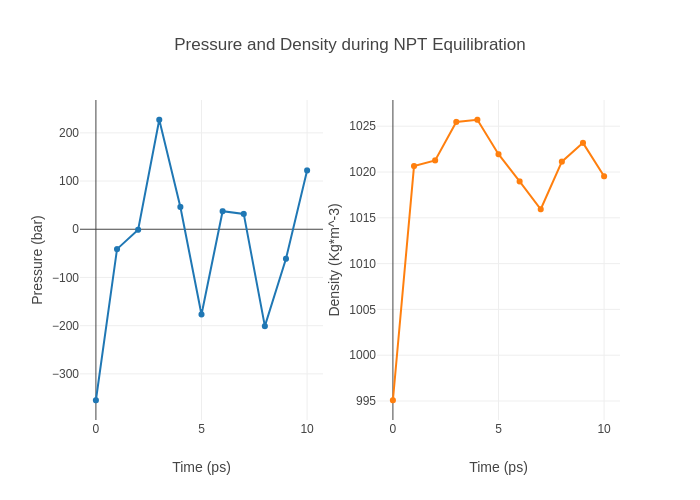

In [106]:
import plotly.io as pio
from IPython.display import Image
Image(pio.to_image(fig, format='png', width='700'))

<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein system**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**BioBB REST API** end points used:
 - [Grompp](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/grompp) from **biobb_md.gromacs.grompp**
 - [Mdrun](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_md/mdrun) from **biobb_md.gromacs.mdrun**
 - [GMXRms](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_rms) from **biobb_analysis.gromacs.gmx_rms**
 - [GMXRgyr](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr**
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

The **free** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **free MD simulation** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  integrator               = md
-  dt                       = 0.002 (ps)
-  nsteps                   = 50000

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, and a total of **50,000 md steps** (100ps).

*Please note that for the sake of time this tutorial is only running 100ps of free MD, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/08_MD.html) the simulated time was 1ns (1000ps).*

In [59]:
# Grompp: Creating portable binary run file for mdrun

# Create prop dict and inputs/outputs
output_gppmd_tpr = pdbCode + '_gppmd.tpr'
prop = {
    'mdp':{
        'type': 'free',
        'nsteps':'50000',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/grompp',
                   config = prop,
                   input_gro_path = output_npt_gro,
                   input_top_zip_path = output_genion_top_zip,
                   output_tpr_path = output_gppmd_tpr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "284d0650e0f56cbb4e6012466397bb95f0a8b4673ad16fa5d04900b83dbe2a4973cd99a6795f46de10fc55a67787875fd1e672d043cb8c9852841279b3dfdfa7"
}


In [60]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:08
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e416f538a2376.17199447",
      "name": "1AKI_gppmd.tpr",
      "size": 1426804,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [61]:
# Save generated file to disk
retrieve_data(out_files)

<a id="mdStep2"></a>
### Step 2: Running short free MD simulation

In [62]:
# Mdrun: Running free dynamics

# Create inputs/outputs
output_md_trr = pdbCode + '_md.trr'
output_md_gro = pdbCode + '_md.gro'
output_md_edr = pdbCode + '_md.edr'
output_md_log = pdbCode + '_md.log'
output_md_cpt = pdbCode + '_md.cpt'

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_md/mdrun',
                   input_tpr_path = output_gppmd_tpr,
                   output_trr_path = output_md_trr,
                   output_gro_path = output_md_gro,
                   output_edr_path = output_md_edr,
                   output_log_path = output_md_log,
                   output_cpt_path = output_md_cpt)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "9384d0f717256940f77316b516655e27a1ab6cd7273e45ba89a051a4e0807425de1f779a2210924d102fb7470edc6947503b24cbfd78be04e9b20e736922e7d4"
}


In [63]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:09:00
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e41716bd931a2.95790805",
      "name": "1AKI_md.trr",
      "size": 8934024,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e41716c3b59c0.49940652",
      "name": "1AKI_md.gro",
      "size": 2334738,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e41716c574183.27358688",
      "name": "1AKI_md.edr",
      "size": 8208,
      "mimetype": "application/octet-stream"
    },
    {
      "id": "5e41716c58bae9.39438357",
      "name": "1AKI_md.log",
      "size": 28127,
      "mimetype": "text/plain"
    },
    {
      "id": "5e41716c5a53d8.68497017",
      "name": "1AKI_md.cpt",
      "size": 814148,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 G

In [64]:
# Save generated file to disk
retrieve_data(out_files)

<a id="mdStep3"></a>
### Step 3: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [65]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against minimized and equilibrated snapshot (backbone atoms)  

# Create prop dict and inputs/outputs
output_rms_first = pdbCode + '_rms_first.xvg'
prop = {
    'selection':  'Backbone',
    #'selection': 'non-Water'
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_rms', 
                   config = prop,
                   input_structure_path = output_gppmd_tpr,
                   input_traj_path = output_md_trr,
                   output_xvg_path = output_rms_first)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "4d464cf5f1affee72d89fe0511f00cf17a385f26be2d18803db9724056d8bcaa03cd5a0091823e32a0e9f0fc2cf521ed25aede08c64e7110acc3ae4139da104f"
}


In [66]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:01
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e41718cf3f647.85446047",
      "name": "1AKI_rms_first.xvg",
      "size": 286,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [67]:
# Save generated file to disk
retrieve_data(out_files)

In [68]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)  

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode + '_rms_exp.xvg'
prop = {
    'selection':  'Backbone',
    #'selection': 'non-Water'
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_rms',
                   config = prop,
                   input_structure_path = output_gppmin_tpr,
                   input_traj_path = output_md_trr,
                   output_xvg_path = output_rms_exp)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "542740101633d37de765f7f032f8ef89b6f8dfb7dd5a7fc30426762d74abe027941e195d78e9a0892a8493e341ec2f590ab5b502ae97dc7326d1fe782babbe93"
}


In [69]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:08
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e41719bed6f92.75831025",
      "name": "1AKI_rms_exp.xvg",
      "size": 286,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [70]:
# Save generated file to disk
retrieve_data(out_files)

In [71]:
import plotly
import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first,'r') as rms_first_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_first_file 
            if not line.startswith(("#","@")) 
        ])
    )

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2,y2 = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_exp_file
            if not line.startswith(("#","@")) 
        ])
    )
    
trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'RMSd vs first'
)

trace2 = go.Scatter(
    x = x,
    y = y2,
    name = 'RMSd vs exp'
)

data = [trace1, trace2]

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": data,
    "layout": go.Layout(title="RMSd during free MD Simulation",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "RMSd (nm)")
                       )
}

plotly.offline.iplot(fig)


In [72]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

# Create prop dict and inputs/outputs
output_rgyr = pdbCode + '_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_rgyr', 
                   config = prop,
                   input_structure_path = output_gppmin_tpr,
                   input_traj_path = output_md_trr,
                   output_xvg_path = output_rgyr)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "47ad6949025b910239dfb4a4e68dc678afc749817bda6bddefd65c54b40adfbf81fdf78fbf19a3792a75ad173cfb0304274a712cc99cd9d1047a9bfeab86ec0f"
}


In [73]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:06
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e4171ab12e6e8.86932407",
      "name": "1AKI_rgyr.xvg",
      "size": 649,
      "mimetype": "text/plain"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [74]:
# Save generated file to disk
retrieve_data(out_files)

In [75]:
import plotly
import plotly.graph_objs as go

# Read Rgyr data from file 
with open(output_rgyr,'r') as rgyr_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rgyr_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Radius of Gyration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Rgyr (nm)")
                       )
}

plotly.offline.iplot(fig)

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**BioBB REST API** end points used:
 - [GMXImage](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_image) from **biobb_analysis.gromacs.gmx_image**
 - [GMXTrjConvStr](http://mmb.irbbarcelona.org/biobb-api/rest/v1/launch/biobb_analysis/gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str**
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [76]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode + '_imaged_traj.trr'
prop = {
    'center_selection':  'Protein',
    'output_selection': 'Protein',
    'pbc' : 'mol',
    'center' : True
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_image',
                   config = prop,
                   input_traj_path = output_md_trr,
                   input_top_path = output_gppmd_tpr,
                   output_traj_path = output_imaged_traj)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "0371185c7fffbd7c4ffb707a1ebe36d3f22185822ea97fa1f5dbd769511239740353ed9463161406ae1899ec5998402bb780c2a74cf81fec3ebdf45c85559f11"
}


In [77]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:02
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e4171ba103c68.50525053",
      "name": "1AKI_imaged_traj.trr",
      "size": 518760,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [78]:
# Save generated file to disk
retrieve_data(out_files)

<a id="ppStep2"></a>
### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [79]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode + '_md_dry.gro'
prop = {
    'selection':  'Protein'
}

# Launch bb on REST API
token = launch_job(url = apiURL + 'launch/biobb_analysis/gmx_trjconv_str',
                   config = prop,
                   input_structure_path = output_md_gro,
                   input_top_path = output_gppmd_tpr,
                   output_str_path = output_dry_gro)

{
  "code": 303,
  "state": "RUNNING",
  "message": "The requested job has has been successfully launched, please go to /retrieve/status/{token} for checking job status.",
  "token": "aa2d46703aa21af2c1ca85d5c5ce7cde0d8bcd54d3255c4d83c92148e56709d72da22aeb8cbbfba7fbc4fca06f752bde06d37b228d89fc33f3938e5f55e01a6a"
}


In [80]:
# Check job status
out_files = check_job(token)

Total elapsed time: 0:00:09
REST API JSON response:
{
  "code": 200,
  "state": "FINISHED",
  "message": "The requested job has finished successfully, please go to /retrieve/data/{id} for each output_files.",
  "output_files": [
    {
      "id": "5e4171c901ab32.33969844",
      "name": "1AKI_md_dry.gro",
      "size": 135294,
      "mimetype": "application/octet-stream"
    }
  ],
  "expiration": "February 12, 2020 00:00 GMT+0000"
}


In [81]:
# Save generated file to disk
retrieve_data(out_files)

<a id="ppStep3"></a>
### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [96]:
# Show trajectory
view = nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_dry_gro), gui=True)
view

NGLWidget(count=11)

In [97]:
from time import sleep
# range number of frames for the animated gif trajectory
for frame in range(0, 11):
    # set frame to update coordinates
    view.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    view.download_image(filename='trj_image{}.png'.format(frame))
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(2.0)

In [98]:
import moviepy.editor as mpy

In [99]:
# go to folder where the images are stored
template = './trj_image{}.png'
# get all (sorted) image files
imagefiles = [template.format(str(i)) for i in range(0, 10, 1)]

In [100]:
# make a gif file
frame_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frame_per_second)
im.write_gif('trajectory.gif', fps=frame_per_second)

t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]

MoviePy - Building file trajectory.gif with imageio.


<img src='trajectory.gif'></img>

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_md_gro}}: **Final structure** (snapshot) of the MD setup protocol.
 - {{output_md_trr}}: **Final trajectory** of the MD setup protocol.
 - {{output_md_cpt}}: **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - {{output_gppmd_tpr}}: **Final tpr file**, GROMACS portable binary run input file. This file contains the starting structure of the **MD setup free MD simulation step**, together with the molecular topology and all the simulation parameters. It can be used to **extend** the simulation.
 - {{output_genion_top_zip}}: **Final topology** of the MD system. It is a compressed zip file including a **topology file** (.top) and a set of auxiliar **include topology** files (.itp).

**Analysis** (MD setup check) output files generated:
 - {{output_rms_first}}: **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - {{output_rms_exp}}: **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - {{output_rgyr}}: **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 